## 🧠 Model Training

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_predict, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
trainwdrop_log = pd.read_csv('../dataset/cleanedwdrop_log_encode_sales_data.csv')
trainwfill_log = pd.read_csv('../dataset/cleanedwfill_log_encode_sales_data.csv')
trainwdrop_iso = pd.read_csv('../dataset/cleanedwdrop_iso_encode_sales_data.csv')
trainwfill_iso = pd.read_csv('../dataset/cleanedwfill_iso_encode_sales_data.csv')

In [3]:
trainwdrop_log.drop(columns=['year'], inplace=True)
trainwdrop_iso.drop(columns=['year'], inplace=True)

trainwfill_log.drop(columns=['year', 'manufacturer', 'model'], inplace=True)
trainwfill_iso.drop(columns=['year', 'manufacturer', 'model'], inplace=True)

In [4]:
#odometer can car_age into int
trainwdrop_log['car_age'] = trainwdrop_log['car_age'].astype(int)
trainwdrop_iso['car_age'] = trainwdrop_iso['car_age'].astype(int)
trainwfill_log['car_age'] = trainwfill_log['car_age'].astype(int)
trainwfill_iso['car_age'] = trainwfill_iso['car_age'].astype(int)

trainwdrop_log['odometer'] = trainwdrop_log['odometer'].astype(int)
trainwdrop_iso['odometer'] = trainwdrop_iso['odometer'].astype(int)
trainwfill_log['odometer'] = trainwfill_log['odometer'].astype(int)
trainwfill_iso['odometer'] = trainwfill_iso['odometer'].astype(int)

In [5]:
models = {
    "LinearRegression": LinearRegression(),
    "RidgeRegression": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_jobs=-1, random_state=42),
    "XGBoost": XGBRegressor(n_jobs=-1, random_state=42, verbosity=0, tree_method='gpu_hist')
}

In [6]:
datasets = {
    "Drop Log": trainwdrop_log.copy(),
    "Drop Iso": trainwdrop_iso.copy(),
    "Fill Log": trainwfill_log.copy(),
    "Fill Iso": trainwfill_iso.copy()
}

In [7]:
def evaluate(y, y_pred):
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    pmae = (mae / y.mean()) * 100
    return r2, rmse, mae, pmae

In [8]:
from tqdm.auto import tqdm
import pandas as pd
from sklearn.model_selection import KFold, cross_val_predict

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results_no_hyper_tune = []

# Total iterations = number of datasets * number of models
total_iters = len(datasets) * len(models)

# Create progress bar
pbar = tqdm(total=total_iters, desc="Evaluating Models", leave=True)

# --- LOOP THROUGH DATASETS & MODELS ---
for name, df in datasets.items():
    X = df.drop(columns=["price"])
    y = df["price"]

    for model_name, model in models.items():
        y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)
        r2, rmse, mae, pmae = evaluate(y, y_pred)

        results_no_hyper_tune.append({
            "Dataset": name,
            "Model": model_name,
            "R²": round(r2, 4),
            "RMSE": round(rmse, 2),
            "MAE": round(mae, 2),
            "PMAE (%)": round(pmae, 2)
        })

        # Update progress
        pbar.update(1)

pbar.close()


Evaluating Models:   0%|          | 0/16 [00:00<?, ?it/s]

In [126]:
import pandas as pd

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_no_hyper_tune)

# Improved styled DataFrame for better header and width display
styled_results = results_df.style.format({
    "R²": "{:.4f}",
    "RMSE": "{:,.2f}",
    "MAE": "{:,.2f}",
    "PMAE (%)": "{:.2f}"
}).background_gradient(subset=["R²"], cmap="Blues") \
  .background_gradient(subset=["RMSE", "MAE", "PMAE (%)"], cmap="Reds_r") \
  .set_table_styles([
    {"selector": "thead th", "props": [
        ("background-color", "#1976D2"),
        ("color", "white"),
        ("font-weight", "bold"),
        ("text-align", "center"),
        ("white-space", "nowrap"),
        ("padding", "10px")
    ]},
    {"selector": "tbody td", "props": [
        ("border", "1px solid #ddd"),
        ("text-align", "center"),
        ("padding", "8px"),
        ("white-space", "nowrap")
    ]},
    {"selector": "table", "props": [
        ("width", "100%"),
        ("table-layout", "fixed")
    ]}
]) \
  .set_properties(**{"text-align": "center"})

styled_results


,Dataset,Model,R²,RMSE,MAE,PMAE (%)
0,Drop Log,LinearRegression,0.6535,"6,384.77","4,611.21",35.27
1,Drop Log,RidgeRegression,0.6535,"6,384.77","4,611.21",35.27
2,Drop Log,RandomForest,0.8916,"3,571.32","2,001.97",15.31
3,Drop Log,XGBoost,0.8920,"3,564.99","2,216.08",16.95
4,Drop Iso,LinearRegression,0.5603,"6,691.75","4,818.05",37.80
5,Drop Iso,RidgeRegression,0.5603,"6,691.75","4,818.04",37.80
6,Drop Iso,RandomForest,0.8799,"3,497.22","2,038.81",15.99
7,Drop Iso,XGBoost,0.8704,"3,633.03","2,332.95",18.30
8,Fill Log,LinearRegression,0.6900,"7,444.66","5,264.40",28.39
9,Fill Log,RidgeRegression,0.6900,"7,444.66","5,264.40",28.39


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# for result in results_no_hyper_tune:
#     dataset_name = result["Dataset"]
#     model_name = result["Model"]

#     # Retrieve the corresponding dataset and model
#     df = datasets[dataset_name]
#     model = models[model_name]

#     X = df.drop(columns=["price"])
#     y = df["price"]

#     # Generate predictions using cross_val_predict
#     y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)

#     # Plot the results
#     plt.figure(figsize=(18, 14))
#     plt.hexbin(y, y_pred, gridsize=70, mincnt=1, linewidths=0.5, edgecolors='gray', cmap='Blues', bins='log')
#     plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label='Perfect Prediction')
#     plt.xlabel("Actual Price")
#     plt.ylabel("Predicted Price")
#     plt.title(f"{dataset_name} - {model_name}")
#     plt.colorbar(label="Density")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()


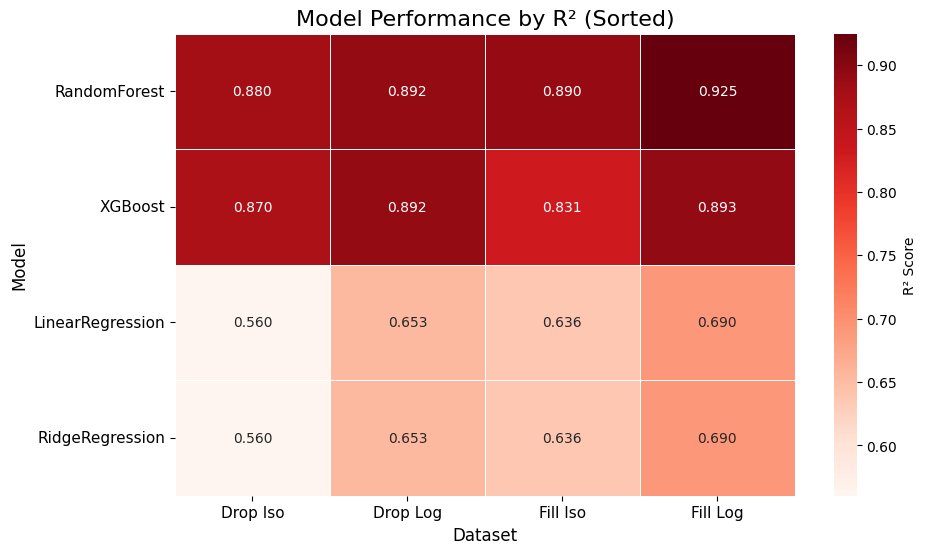

In [11]:
# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_no_hyper_tune)

# Create a pivot table for the heatmap
heatmap_data = results_df.pivot(index="Model", columns="Dataset", values="R²")

# Calculate the average R² and sort by it
heatmap_data["Avg R²"] = heatmap_data.mean(axis=1)
heatmap_data.sort_values("Avg R²", ascending=False, inplace=True)
heatmap_data.drop(columns="Avg R²", inplace=True)

# Red theme color map
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="Reds",          # red theme
    linewidths=0.5,
    linecolor='white',
    cbar_kws={"label": "R² Score"}
)

plt.title("Model Performance by R² (Sorted)", fontsize=16)
plt.xlabel("Dataset", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

In [12]:
from sklearn.base import clone

# Prepare data
X_Fill = datasets["Fill Log"].drop(columns=["price"])
y_Fill = datasets["Fill Log"]["price"]

X_Drop = datasets["Drop Log"].drop(columns=["price"])
y_Drop = datasets["Drop Log"]["price"]

# Fit model
model = clone(models["RandomForest"]).fit(X, y)

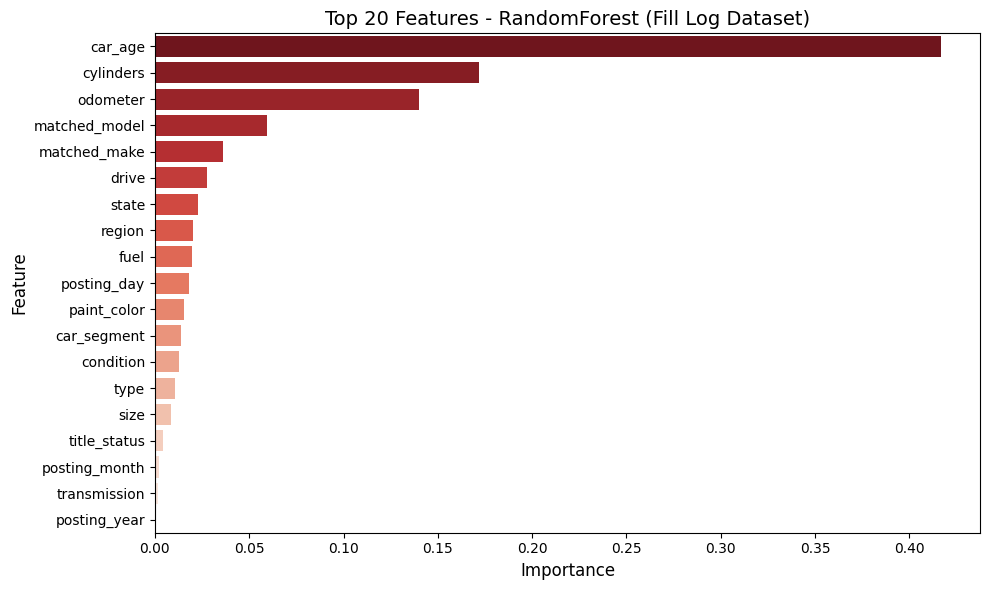

In [13]:
# Extract feature importances and select top 20
importances_fill = pd.Series(model.feature_importances_, index=X_Fill.columns).sort_values(ascending=False).head(20)

# Convert to DataFrame for seaborn
top_features_df = importances_fill.reset_index()
top_features_df.columns = ['Feature', 'Importance']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_features_df,
    x='Importance',
    y='Feature',
    hue='Feature',
    palette='Reds_r',
    dodge=False,
    legend=False  # hide redundant legend
)
plt.title("Top 20 Features - RandomForest (Fill Log Dataset)", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

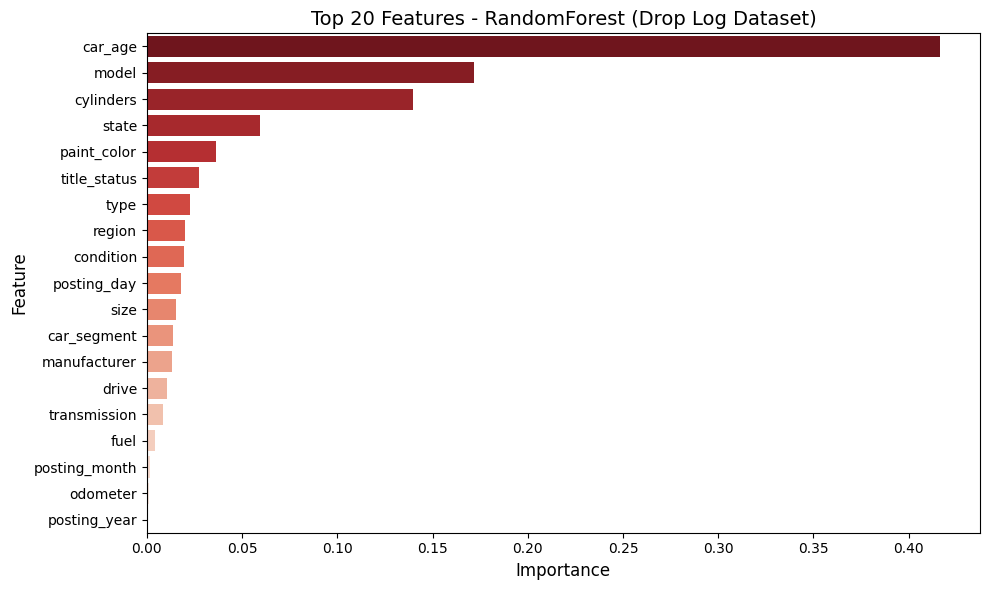

In [14]:
# Extract feature importances and select top 20
importances_drop = pd.Series(model.feature_importances_, index=X_Drop.columns).sort_values(ascending=False).head(20)

# Convert to DataFrame for seaborn
top_features_df = importances_drop.reset_index()
top_features_df.columns = ['Feature', 'Importance']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_features_df,
    x='Importance',
    y='Feature',
    hue='Feature',
    palette='Reds_r',
    dodge=False,
    legend=False  # hide redundant legend
)
plt.title("Top 20 Features - RandomForest (Drop Log Dataset)", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

note : redundency on car_age and year drop `year`

In [15]:
importances_fill * 100

car_age          41.658839
cylinders        17.175320
odometer         13.975871
matched_model     5.918651
matched_make      3.609138
drive             2.746318
state             2.271654
region            1.993686
fuel              1.976838
posting_day       1.789746
paint_color       1.548390
car_segment       1.366275
condition         1.300085
type              1.057283
size              0.836411
title_status      0.442145
posting_month     0.193731
transmission      0.139621
posting_year      0.000000
dtype: float64

In [16]:
importances_drop * 100

car_age          41.658839
model            17.175320
cylinders        13.975871
state             5.918651
paint_color       3.609138
title_status      2.746318
type              2.271654
region            1.993686
condition         1.976838
posting_day       1.789746
size              1.548390
car_segment       1.366275
manufacturer      1.300085
drive             1.057283
transmission      0.836411
fuel              0.442145
posting_month     0.193731
odometer          0.139621
posting_year      0.000000
dtype: float64

In [17]:
select_feature_fill = importances_fill[:9].index
select_feature_fill

Index(['car_age', 'cylinders', 'odometer', 'matched_model', 'matched_make',
       'drive', 'state', 'region', 'fuel'],
      dtype='object')

In [18]:
select_feature_drop = importances_drop[:9].index
select_feature_drop

Index(['car_age', 'model', 'cylinders', 'state', 'paint_color', 'title_status',
       'type', 'region', 'condition'],
      dtype='object')

In [19]:
importances_fill[select_feature_fill].sum()

np.float64(0.9132631390682147)

In [20]:
importances_drop[select_feature_drop].sum()

np.float64(0.9132631390682147)

## 🛠️Feature Selection & Hypertune

In [78]:
datasets = {
    "Drop Log": datasets["Drop Log"][select_feature_drop.tolist() + ['price']].copy(),
    "Drop Iso": datasets["Drop Iso"][select_feature_drop.tolist() + ['price']].copy(),
    "Fill Log": datasets["Fill Log"][select_feature_fill.tolist() + ['price']].copy(),
    "Fill Iso": datasets["Fill Iso"][select_feature_fill.tolist() + ['price']].copy()
}

In [79]:
from tqdm.auto import tqdm, trange
import optuna
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import pandas as pd

results_tuned = []
best_params = {}

# --- Early stopping callback ---
class EarlyStoppingCallback:
    def __init__(self, patience):
        self.patience = patience
        self.best_value = float('inf')
        self.counter = 0

    def __call__(self, study, trial):
        if study.best_value < self.best_value:
            self.best_value = study.best_value
            self.counter = 0
        else:
            self.counter += 1
        if self.counter >= self.patience:
            print(f"⛔️ Early stopping triggered after {self.patience} trials.")
            study.stop()


In [115]:
# --- Tuning functions ---
def tune_ridge(trial, X, y):
    alpha = trial.suggest_float("alpha", 1e-4, 1e3, log=True)  # Wide range for alpha
    model = Ridge(alpha=alpha)
    y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)
    sse = np.sum((y - y_pred) ** 2)
    return sse 

def tune_rf(trial, X, y):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 150), # fewer trees
        "max_depth": trial.suggest_int("max_depth", 3, 10), # shallower trees
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 5), # less granular
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 3), # fewer samples per leaf
    }
    model = RandomForestRegressor(**params, n_jobs=-1, random_state=42)
    y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)
    sse = np.sum((y - y_pred) ** 2)
    return sse 

def tune_xgb(trial, X, y):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 16),

        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'tree_method': 'gpu_hist',
        'random_state': 42
    }
    model = XGBRegressor(**params, n_jobs=-1)
    y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)
    sse = np.sum((y - y_pred) ** 2)
    return sse 


In [81]:
# --- Main tuning loop ---
def run_tuning(dataset_name, model_name, datasets, n_trials=None, patience=None):
    X = datasets[dataset_name].drop(columns=["price"])
    y = datasets[dataset_name]["price"]

    # Check if the model has already been trained on this dataset
    existing_result_index = next(
        (i for i, result in enumerate(results_tuned) 
         if result["Dataset"] == dataset_name and result["Model"].startswith(model_name)), 
        None
    )

    if existing_result_index is not None:
        print(f"✅ {model_name} on {dataset_name} has already been tuned. Retraining and updating results.")
    else:
        print(f"🔧 Starting {model_name} on {dataset_name} with {n_trials} trials")

    # Set default trial/patience if not specified
    if n_trials is None:
        n_trials = 100 if model_name == "RidgeRegression" else 40
    if patience is None:
        patience = 40 if model_name == "RidgeRegression" else 12

    def objective(trial):
        if model_name == "RidgeRegression":
            return tune_ridge(trial, X, y)
        elif model_name == "RandomForest":
            return tune_rf(trial, X, y)
        elif model_name == "XGBoost":
            return tune_xgb(trial, X, y)

    early_stopping = EarlyStoppingCallback(patience=patience)

    # Progress bar wrapper
    with tqdm(total=n_trials, desc=f"{dataset_name} | {model_name}", leave=False) as pbar:
        def progress_bar_callback(study, trial):
            pbar.update(1)

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=n_trials,
                       callbacks=[early_stopping, progress_bar_callback])

    best_params[(dataset_name, model_name)] = study.best_params

    # Retrain and evaluate
    if model_name == "RidgeRegression":
        model = Ridge(**study.best_params)
    elif model_name == "RandomForest":
        model = RandomForestRegressor(**study.best_params, random_state=42, n_jobs=-1)
    elif model_name == "XGBoost":
        model = XGBRegressor(**study.best_params, random_state=42, n_jobs=-1, verbosity=0)

    y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)

    y_true = np.expm1(y) if dataset_name == "Log" else y
    y_pred = np.expm1(y_pred) if dataset_name == "Log" else y_pred

    r2, rmse, mae, pmae = evaluate(y_true, y_pred)

    # Update or append the result based on whether it's already in results_tuned
    result = {
        "Dataset": dataset_name,
        "Model": model_name + " (Tuned)",
        "R²": round(r2, 4),
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "PMAE (%)": round(pmae, 2)
    }

    if existing_result_index is not None:
        # Update the existing result in results_tuned
        results_tuned[existing_result_index] = result
    else:
        # Append as a new result if it's not already present
        results_tuned.append(result)

    print(f"✅ Finished {model_name} on {dataset_name}")


In [82]:
for dataset in ["Drop Log", "Drop Iso"]:
    for model in ["RidgeRegression", "RandomForest", "XGBoost"]:
        run_tuning(dataset, model, datasets)

🔧 Starting RidgeRegression on Drop Log with None trials


Drop Log | RidgeRegression:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-12 19:35:44,847] A new study created in memory with name: no-name-b2aea154-bf21-460c-a710-0c7d3b893f90
[I 2025-05-12 19:35:48,009] Trial 0 finished with value: 4021588620001.64 and parameters: {'alpha': 834.4484116955854}. Best is trial 0 with value: 4021588620001.64.
[I 2025-05-12 19:35:49,469] Trial 1 finished with value: 4021502776774.754 and parameters: {'alpha': 0.022397464441556107}. Best is trial 1 with value: 4021502776774.754.
[I 2025-05-12 19:35:51,058] Trial 2 finished with value: 4021502772658.102 and parameters: {'alpha': 0.4891777238422319}. Best is trial 2 with value: 4021502772658.102.
[I 2025-05-12 19:35:52,247] Trial 3 finished with value: 4021502776773.3877 and parameters: {'alpha': 0.022551235200347942}. Best is trial 2 with value: 4021502772658.102.
[I 2025-05-12 19:35:52,430] Trial 4 finished with value: 4021503251920.9673 and parameters: {'alpha': 97.64197810256795}. Best is trial 2 with value: 4021502772658.102.
[I 2025-05-12 19:35:52,591] Trial 5 fin

⛔️ Early stopping triggered after 40 trials.
✅ Finished RidgeRegression on Drop Log
🔧 Starting RandomForest on Drop Log with None trials


Drop Log | RandomForest:   0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-05-12 19:36:00,848] A new study created in memory with name: no-name-1545cd4d-65e5-4e2f-9590-25b6da0ecd01
[I 2025-05-12 19:36:02,581] Trial 0 finished with value: 2518007997193.465 and parameters: {'n_estimators': 77, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 2518007997193.465.
[I 2025-05-12 19:36:06,208] Trial 1 finished with value: 1869999533934.596 and parameters: {'n_estimators': 130, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 1 with value: 1869999533934.596.
[I 2025-05-12 19:36:08,793] Trial 2 finished with value: 2519304140969.826 and parameters: {'n_estimators': 128, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 1 with value: 1869999533934.596.
[I 2025-05-12 19:36:09,658] Trial 3 finished with value: 3483487359856.88 and parameters: {'n_estimators': 60, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 1 with value: 186999953393

⛔️ Early stopping triggered after 12 trials.
✅ Finished RandomForest on Drop Log
🔧 Starting XGBoost on Drop Log with None trials


Drop Log | XGBoost:   0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-05-12 19:36:56,310] A new study created in memory with name: no-name-af872727-09b9-4d54-a4d3-6150f359fca4
[I 2025-05-12 19:36:57,742] Trial 0 finished with value: 1820844782110.7068 and parameters: {'learning_rate': 0.26313269940277056, 'n_estimators': 113, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 0.9289994507113537, 'subsample': 0.9110221884117242, 'colsample_bytree': 0.9258966220083075, 'reg_alpha': 0.7629074844504092, 'reg_lambda': 0.12608941173256805}. Best is trial 0 with value: 1820844782110.7068.
[I 2025-05-12 19:37:00,383] Trial 1 finished with value: 1314472354693.9744 and parameters: {'learning_rate': 0.1973181692553719, 'n_estimators': 159, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.6904819856691053, 'subsample': 0.9729520174626255, 'colsample_bytree': 0.8500204062044011, 'reg_alpha': 0.4218020059199963, 'reg_lambda': 0.48242583286569385}. Best is trial 1 with value: 1314472354693.9744.
[I 2025-05-12 19:37:02,629] Trial 2 finished with value: 1483252669

⛔️ Early stopping triggered after 12 trials.
✅ Finished XGBoost on Drop Log
🔧 Starting RidgeRegression on Drop Iso with None trials


Drop Iso | RidgeRegression:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-12 19:37:54,451] A new study created in memory with name: no-name-1aae41e3-7446-4ffc-b82a-5e6f6ff4cf91
[I 2025-05-12 19:37:54,634] Trial 0 finished with value: 4198586753747.3755 and parameters: {'alpha': 0.0857194131059763}. Best is trial 0 with value: 4198586753747.3755.
[I 2025-05-12 19:37:54,796] Trial 1 finished with value: 4198586752321.3804 and parameters: {'alpha': 0.13058874955415206}. Best is trial 1 with value: 4198586752321.3804.
[I 2025-05-12 19:37:54,978] Trial 2 finished with value: 4198586756347.031 and parameters: {'alpha': 0.003946366133775207}. Best is trial 1 with value: 4198586752321.3804.
[I 2025-05-12 19:37:55,140] Trial 3 finished with value: 4198586651494.3203 and parameters: {'alpha': 3.3290639792091445}. Best is trial 3 with value: 4198586651494.3203.
[I 2025-05-12 19:37:55,301] Trial 4 finished with value: 4198586756323.0874 and parameters: {'alpha': 0.004699356311723612}. Best is trial 3 with value: 4198586651494.3203.
[I 2025-05-12 19:37:55,463]

✅ Finished RidgeRegression on Drop Iso
🔧 Starting RandomForest on Drop Iso with None trials


Drop Iso | RandomForest:   0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-05-12 19:38:10,951] A new study created in memory with name: no-name-3f396513-fac1-471d-baee-1b18f43ddeb3
[I 2025-05-12 19:38:13,921] Trial 0 finished with value: 1811282151161.0823 and parameters: {'n_estimators': 88, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 1811282151161.0823.
[I 2025-05-12 19:38:16,014] Trial 1 finished with value: 2723055936350.001 and parameters: {'n_estimators': 95, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 1811282151161.0823.
[I 2025-05-12 19:38:18,803] Trial 2 finished with value: 2005189041693.2786 and parameters: {'n_estimators': 92, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 1811282151161.0823.
[I 2025-05-12 19:38:21,205] Trial 3 finished with value: 2723109406995.9424 and parameters: {'n_estimators': 112, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 18112

⛔️ Early stopping triggered after 12 trials.
✅ Finished RandomForest on Drop Iso
🔧 Starting XGBoost on Drop Iso with None trials


Drop Iso | XGBoost:   0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-05-12 19:39:34,027] A new study created in memory with name: no-name-d61dd658-e1ab-4e13-94a9-3214bde8229e
[I 2025-05-12 19:39:35,245] Trial 0 finished with value: 2300850971532.054 and parameters: {'learning_rate': 0.25319939701754324, 'n_estimators': 132, 'max_depth': 2, 'min_child_weight': 2, 'gamma': 0.01658162098903404, 'subsample': 0.9563611305690147, 'colsample_bytree': 0.8877998439260802, 'reg_alpha': 0.9672833303037099, 'reg_lambda': 0.4231109686318879}. Best is trial 0 with value: 2300850971532.054.
[I 2025-05-12 19:39:36,277] Trial 1 finished with value: 2277356309388.1914 and parameters: {'learning_rate': 0.12578574415657418, 'n_estimators': 101, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.7603445052493089, 'subsample': 0.9163591939175011, 'colsample_bytree': 0.8654025656414706, 'reg_alpha': 0.9661953303390579, 'reg_lambda': 0.4379057761050601}. Best is trial 1 with value: 2277356309388.1914.
[I 2025-05-12 19:39:38,628] Trial 2 finished with value: 141695530688

⛔️ Early stopping triggered after 12 trials.
✅ Finished XGBoost on Drop Iso


In [84]:
for dataset in ["Fill Log", "Fill Iso"]:
    for model in ["RidgeRegression", "RandomForest", "XGBoost"]:
        run_tuning(dataset, model, datasets)

🔧 Starting RidgeRegression on Fill Log with None trials


Fill Log | RidgeRegression:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-12 19:40:55,438] A new study created in memory with name: no-name-90c86ec2-3494-4e8e-8419-5aee7d4cd06f
[I 2025-05-12 19:40:55,763] Trial 0 finished with value: 17884986413890.3 and parameters: {'alpha': 0.022655719014070933}. Best is trial 0 with value: 17884986413890.3.
[I 2025-05-12 19:40:56,312] Trial 1 finished with value: 17884986414051.785 and parameters: {'alpha': 0.0004718193806270124}. Best is trial 0 with value: 17884986413890.3.
[I 2025-05-12 19:40:56,634] Trial 2 finished with value: 17884986413998.082 and parameters: {'alpha': 0.007836268074434}. Best is trial 0 with value: 17884986413890.3.
[I 2025-05-12 19:40:56,919] Trial 3 finished with value: 17884986413740.38 and parameters: {'alpha': 0.04335509888769757}. Best is trial 3 with value: 17884986413740.38.
[I 2025-05-12 19:40:57,215] Trial 4 finished with value: 17884990500296.39 and parameters: {'alpha': 73.4454267561563}. Best is trial 3 with value: 17884986413740.38.
[I 2025-05-12 19:40:57,511] Trial 5 fini

⛔️ Early stopping triggered after 40 trials.
✅ Finished RidgeRegression on Fill Log
🔧 Starting RandomForest on Fill Log with None trials


Fill Log | RandomForest:   0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-05-12 19:41:17,485] A new study created in memory with name: no-name-7d92e1d9-8d39-4483-a2cc-125eee2532ec
[I 2025-05-12 19:42:03,098] Trial 0 finished with value: 13504518520931.162 and parameters: {'n_estimators': 135, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 13504518520931.162.
[I 2025-05-12 19:42:50,273] Trial 1 finished with value: 10123425804706.678 and parameters: {'n_estimators': 112, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 1 with value: 10123425804706.678.
[I 2025-05-12 19:43:10,268] Trial 2 finished with value: 13504698252331.57 and parameters: {'n_estimators': 59, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 1 with value: 10123425804706.678.
[I 2025-05-12 19:43:52,619] Trial 3 finished with value: 11161359851857.24 and parameters: {'n_estimators': 105, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 10123

⛔️ Early stopping triggered after 12 trials.
✅ Finished RandomForest on Fill Log
🔧 Starting XGBoost on Fill Log with None trials


Fill Log | XGBoost:   0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-05-12 19:58:27,139] A new study created in memory with name: no-name-08bca3c6-10b2-4d27-9c8e-713ad7fb8f2d
[I 2025-05-12 19:58:30,212] Trial 0 finished with value: 6227268222906.971 and parameters: {'learning_rate': 0.248315323713166, 'n_estimators': 131, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 0.17669432282122144, 'subsample': 0.879695731986435, 'colsample_bytree': 0.9020385060294651, 'reg_alpha': 0.1372194399395964, 'reg_lambda': 0.4630577654292586}. Best is trial 0 with value: 6227268222906.971.
[I 2025-05-12 19:58:32,834] Trial 1 finished with value: 8531496138513.968 and parameters: {'learning_rate': 0.10419167906591825, 'n_estimators': 184, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.8710059055140301, 'subsample': 0.9180391231133262, 'colsample_bytree': 0.9083464409679134, 'reg_alpha': 0.6092183882156995, 'reg_lambda': 0.5603655682635409}. Best is trial 0 with value: 6227268222906.971.
[I 2025-05-12 19:58:36,112] Trial 2 finished with value: 5925255961796.746

⛔️ Early stopping triggered after 12 trials.
✅ Finished XGBoost on Fill Log
🔧 Starting RidgeRegression on Fill Iso with None trials


Fill Iso | RidgeRegression:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-05-12 19:59:38,221] A new study created in memory with name: no-name-aa6214e2-bb5c-4edf-871a-a92ba6c46608
[I 2025-05-12 19:59:38,518] Trial 0 finished with value: 17631844234593.9 and parameters: {'alpha': 0.029070967831537335}. Best is trial 0 with value: 17631844234593.9.
[I 2025-05-12 19:59:38,815] Trial 1 finished with value: 17631844234945.305 and parameters: {'alpha': 0.005176679872905133}. Best is trial 0 with value: 17631844234593.9.
[I 2025-05-12 19:59:39,126] Trial 2 finished with value: 17631844235016.02 and parameters: {'alpha': 0.000373436912058575}. Best is trial 0 with value: 17631844234593.9.
[I 2025-05-12 19:59:39,423] Trial 3 finished with value: 17631844235002.613 and parameters: {'alpha': 0.0012839647900306911}. Best is trial 0 with value: 17631844234593.9.
[I 2025-05-12 19:59:39,702] Trial 4 finished with value: 17631844194964.492 and parameters: {'alpha': 3.0466841078849267}. Best is trial 4 with value: 17631844194964.492.
[I 2025-05-12 19:59:39,997] Trial

✅ Finished RidgeRegression on Fill Iso
🔧 Starting RandomForest on Fill Iso with None trials


Fill Iso | RandomForest:   0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-05-12 20:00:08,601] A new study created in memory with name: no-name-d01c0f21-b399-4205-92fe-0f07e4ac8dce
[I 2025-05-12 20:01:03,649] Trial 0 finished with value: 11573738227700.924 and parameters: {'n_estimators': 136, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 11573738227700.924.
[I 2025-05-12 20:01:16,780] Trial 1 finished with value: 18050173371526.094 and parameters: {'n_estimators': 54, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 11573738227700.924.
[I 2025-05-12 20:01:31,699] Trial 2 finished with value: 15989053715423.652 and parameters: {'n_estimators': 52, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 11573738227700.924.
[I 2025-05-12 20:01:59,327] Trial 3 finished with value: 18041061201304.51 and parameters: {'n_estimators': 115, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 11573

⛔️ Early stopping triggered after 12 trials.
✅ Finished RandomForest on Fill Iso
🔧 Starting XGBoost on Fill Iso with None trials


Fill Iso | XGBoost:   0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-05-12 20:27:31,776] A new study created in memory with name: no-name-208acf9a-6663-4e75-b8c9-bd129eb36f7c
[I 2025-05-12 20:27:34,044] Trial 0 finished with value: 9599235822874.271 and parameters: {'learning_rate': 0.2985213507888909, 'n_estimators': 145, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.14210440265570523, 'subsample': 0.907678466962091, 'colsample_bytree': 0.9949887897852865, 'reg_alpha': 0.8435015947391457, 'reg_lambda': 0.9985588859209229}. Best is trial 0 with value: 9599235822874.271.
[I 2025-05-12 20:27:35,846] Trial 1 finished with value: 8673982113528.777 and parameters: {'learning_rate': 0.26476390075818124, 'n_estimators': 81, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.6179533460837059, 'subsample': 0.9688760586448615, 'colsample_bytree': 0.8900392568224343, 'reg_alpha': 0.5298388977323438, 'reg_lambda': 0.5281181119393942}. Best is trial 1 with value: 8673982113528.777.
[I 2025-05-12 20:27:39,038] Trial 2 finished with value: 8605866174711.693

✅ Finished XGBoost on Fill Iso


In [ ]:
#in case want to train only 1 model --> run_tuning(dataset, model, datasets) ex. run_tuning("Fill Log", "XGBoost", datasets)
# run_tuning("Fill Log", "XGBoost", datasets)

✅ XGBoost on Fill Log has already been tuned. Retraining and updating results.


Fill Log | XGBoost:   0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-05-12 22:35:31,191] A new study created in memory with name: no-name-4caa908d-332b-4ff3-b8db-e972891fabb5
[I 2025-05-12 22:35:38,658] Trial 0 finished with value: 8227782535636.482 and parameters: {'learning_rate': 0.06245718497869745, 'n_estimators': 439, 'max_depth': 4, 'subsample': 0.9416260185074579, 'colsample_bytree': 0.5502130127690585}. Best is trial 0 with value: 8227782535636.482.
[I 2025-05-12 22:36:39,696] Trial 1 finished with value: 4275202169253.61 and parameters: {'learning_rate': 0.24343855155383007, 'n_estimators': 491, 'max_depth': 11, 'subsample': 0.8002353619028308, 'colsample_bytree': 0.8966277406319596}. Best is trial 1 with value: 4275202169253.61.
[I 2025-05-12 22:40:02,987] Trial 2 finished with value: 3825588617337.6855 and parameters: {'learning_rate': 0.06591896411365983, 'n_estimators': 716, 'max_depth': 13, 'subsample': 0.90086969521359, 'colsample_bytree': 0.6852922815732803}. Best is trial 2 with value: 3825588617337.6855.
[I 2025-05-12 22:43:23

⛔️ Early stopping triggered after 12 trials.
✅ Finished XGBoost on Fill Log


In [123]:
import pandas as pd

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_tuned)

# Improved styled DataFrame for better header and width display
styled_results = results_df.style.format({
    "R²": "{:.4f}",
    "RMSE": "{:,.2f}",
    "MAE": "{:,.2f}",
    "PMAE (%)": "{:.2f}"
}).background_gradient(subset=["R²"], cmap="Blues") \
  .background_gradient(subset=["RMSE", "MAE", "PMAE (%)"], cmap="Reds_r") \
  .set_table_styles([
    {"selector": "thead th", "props": [
        ("background-color", "#1976D2"),
        ("color", "white"),
        ("font-weight", "bold"),
        ("text-align", "center"),
        ("white-space", "nowrap"),
        ("padding", "10px")
    ]},
    {"selector": "tbody td", "props": [
        ("border", "1px solid #ddd"),
        ("text-align", "center"),
        ("padding", "8px"),
        ("white-space", "nowrap")
    ]},
    {"selector": "table", "props": [
        ("width", "100%"),
        ("table-layout", "fixed")
    ]}
]) \
  .set_properties(**{"text-align": "center"})

styled_results


,Dataset,Model,R²,RMSE,MAE,PMAE (%)
0,Drop Log,RidgeRegression (Tuned),0.4798,"7,822.38","5,552.51",42.46
1,Drop Log,RandomForest (Tuned),0.7792,"5,096.02","3,297.40",25.22
2,Drop Log,XGBoost (Tuned),0.8376,"4,371.32","2,762.20",21.12
3,Drop Iso,RidgeRegression (Tuned),0.4085,"7,761.64","5,646.39",44.30
4,Drop Iso,RandomForest (Tuned),0.7454,"5,091.90","3,427.61",26.89
5,Drop Iso,XGBoost (Tuned),0.8149,"4,341.83","2,885.91",22.64
6,Fill Log,RidgeRegression (Tuned),0.6787,"7,578.58","5,384.69",29.03
7,Fill Log,RandomForest (Tuned),0.8366,"5,404.93","3,411.58",18.40
8,Fill Log,XGBoost (Tuned),0.9313,"3,505.47","1,785.38",9.63
9,Fill Iso,RidgeRegression (Tuned),0.6225,"7,442.75","5,365.30",30.29


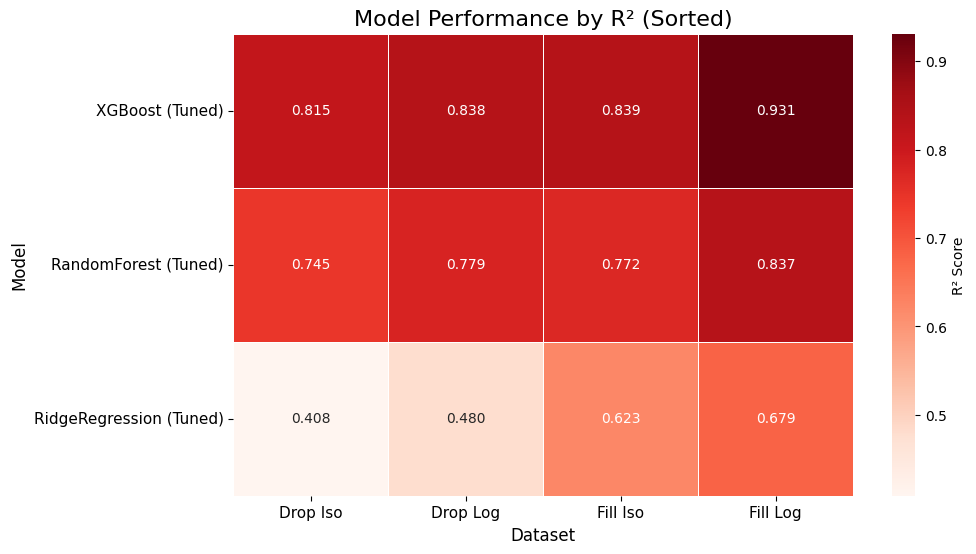

In [124]:
# Convert results_tuned to a DataFrame
results_tuned_df = pd.DataFrame(results_tuned)

# Check if results_tuned_df is empty
if results_tuned_df.empty:
    print("No tuned results available to create a heatmap.")
else:
    # Create a pivot table
    heatmap_data = results_tuned_df.pivot(index="Model", columns="Dataset", values="R²")

    heatmap_data["Avg R²"] = heatmap_data.mean(axis=1)
    heatmap_data.sort_values("Avg R²", ascending=False, inplace=True)
    heatmap_data.drop(columns="Avg R²", inplace=True)

    # Red theme color map
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".3f",
        cmap="Reds",          # red theme
        linewidths=0.5,
        linecolor='white',
        cbar_kws={"label": "R² Score"}
    )

    plt.title("Model Performance by R² (Sorted)", fontsize=16)
    plt.xlabel("Dataset", fontsize=12)
    plt.ylabel("Model", fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.show()


In [125]:
# Convert to DataFrame
df_no_tune = pd.DataFrame(results_no_hyper_tune)
df_tuned = pd.DataFrame(results_tuned)

# Clean up model/dataset names
df_tuned["Model"] = df_tuned["Model"].str.replace(r" \(Tuned\)", "", regex=True)
df_tuned["Dataset"] = df_tuned["Dataset"].str.replace(r" Selected", "", regex=True)

# Merge for comparison
comparison = pd.merge(
    df_no_tune,
    df_tuned,
    on=["Dataset", "Model"],
    suffixes=("_NoTune", "_Tuned")
)

# Compute differences
comparison["Δ R²"] = comparison["R²_Tuned"] - comparison["R²_NoTune"]
comparison["Δ RMSE"] = comparison["RMSE_NoTune"] - comparison["RMSE_Tuned"]
comparison["Δ MAE"] = comparison["MAE_NoTune"] - comparison["MAE_Tuned"]
comparison["Δ PMAE"] = comparison["PMAE (%)_NoTune"] - comparison["PMAE (%)_Tuned"]

# Round for display
comparison = comparison.round(3)

# Sort by R² improvement
comparison.sort_values(by="Δ R²", ascending=False, inplace=True)
comparison.reset_index(drop=True, inplace=True)

# Style the comparison DataFrame
styled_comparison = comparison.style.format({
    "R²_NoTune": "{:.4f}",
    "RMSE_NoTune": "{:,.2f}",
    "MAE_NoTune": "{:,.2f}",
    "PMAE (%)_NoTune": "{:.2f}",
    "R²_Tuned": "{:.4f}",
    "RMSE_Tuned": "{:,.2f}",
    "MAE_Tuned": "{:,.2f}",
    "PMAE (%)_Tuned": "{:.2f}",
    "Δ R²": "{:.4f}",
    "Δ RMSE": "{:,.2f}",
    "Δ MAE": "{:,.2f}",
    "Δ PMAE": "{:.2f}"
}).background_gradient(subset=["R²_NoTune", "R²_Tuned", "Δ R²"], cmap="Blues") \
  .background_gradient(subset=["RMSE_NoTune", "MAE_NoTune", "PMAE (%)_NoTune", "RMSE_Tuned", "MAE_Tuned", "PMAE (%)_Tuned"], cmap="Reds_r") \
  .background_gradient(subset=["Δ RMSE", "Δ MAE", "Δ PMAE"], cmap="Reds") \
  .set_table_styles([
    {"selector": "thead th", "props": [
        ("background-color", "#1976D2"),
        ("color", "white"),
        ("font-weight", "bold"),
        ("text-align", "center"),
        ("white-space", "nowrap"),
        ("padding", "10px")
    ]},
    {"selector": "tbody td", "props": [
        ("border", "1px solid #ddd"),
        ("text-align", "center"),
        ("padding", "8px"),
        ("white-space", "nowrap")
    ]},
    {"selector": "table", "props": [
        ("width", "100%"),
        ("table-layout", "fixed")
    ]}
]) \
  .set_properties(**{"text-align": "center"})

styled_comparison

,Dataset,Model,R²_NoTune,RMSE_NoTune,MAE_NoTune,PMAE (%)_NoTune,R²_Tuned,RMSE_Tuned,MAE_Tuned,PMAE (%)_Tuned,Δ R²,Δ RMSE,Δ MAE,Δ PMAE
0,Fill Log,XGBoost,0.8930,"4,372.10","2,639.08",14.23,0.9310,"3,505.47","1,785.38",9.63,0.0380,866.63,853.70,4.60
1,Fill Iso,XGBoost,0.8310,"4,984.69","3,024.49",17.07,0.8390,"4,856.11","2,944.33",16.62,0.0090,128.58,80.16,0.45
2,Fill Log,RidgeRegression,0.6900,"7,444.66","5,264.40",28.39,0.6790,"7,578.58","5,384.69",29.03,-0.0110,-133.92,-120.29,-0.64
3,Fill Iso,RidgeRegression,0.6360,"7,307.91","5,252.39",29.65,0.6220,"7,442.75","5,365.30",30.29,-0.0140,-134.84,-112.91,-0.64
4,Drop Log,XGBoost,0.8920,"3,564.99","2,216.08",16.95,0.8380,"4,371.32","2,762.20",21.12,-0.0540,-806.33,-546.12,-4.17
5,Drop Iso,XGBoost,0.8700,"3,633.03","2,332.95",18.30,0.8150,"4,341.83","2,885.91",22.64,-0.0550,-708.80,-552.96,-4.34
6,Fill Log,RandomForest,0.9250,"3,666.07","1,735.70",9.36,0.8370,"5,404.93","3,411.58",18.40,-0.0880,"-1,738.86","-1,675.88",-9.04
7,Drop Log,RandomForest,0.8920,"3,571.32","2,001.97",15.31,0.7790,"5,096.02","3,297.40",25.22,-0.1120,"-1,524.70","-1,295.43",-9.91
8,Fill Iso,RandomForest,0.8900,"4,011.87","1,999.36",11.29,0.7720,"5,785.28","3,680.01",20.77,-0.1180,"-1,773.41","-1,680.65",-9.48
9,Drop Iso,RandomForest,0.8800,"3,497.22","2,038.81",15.99,0.7450,"5,091.90","3,427.61",26.89,-0.1350,"-1,594.68","-1,388.80",-10.90


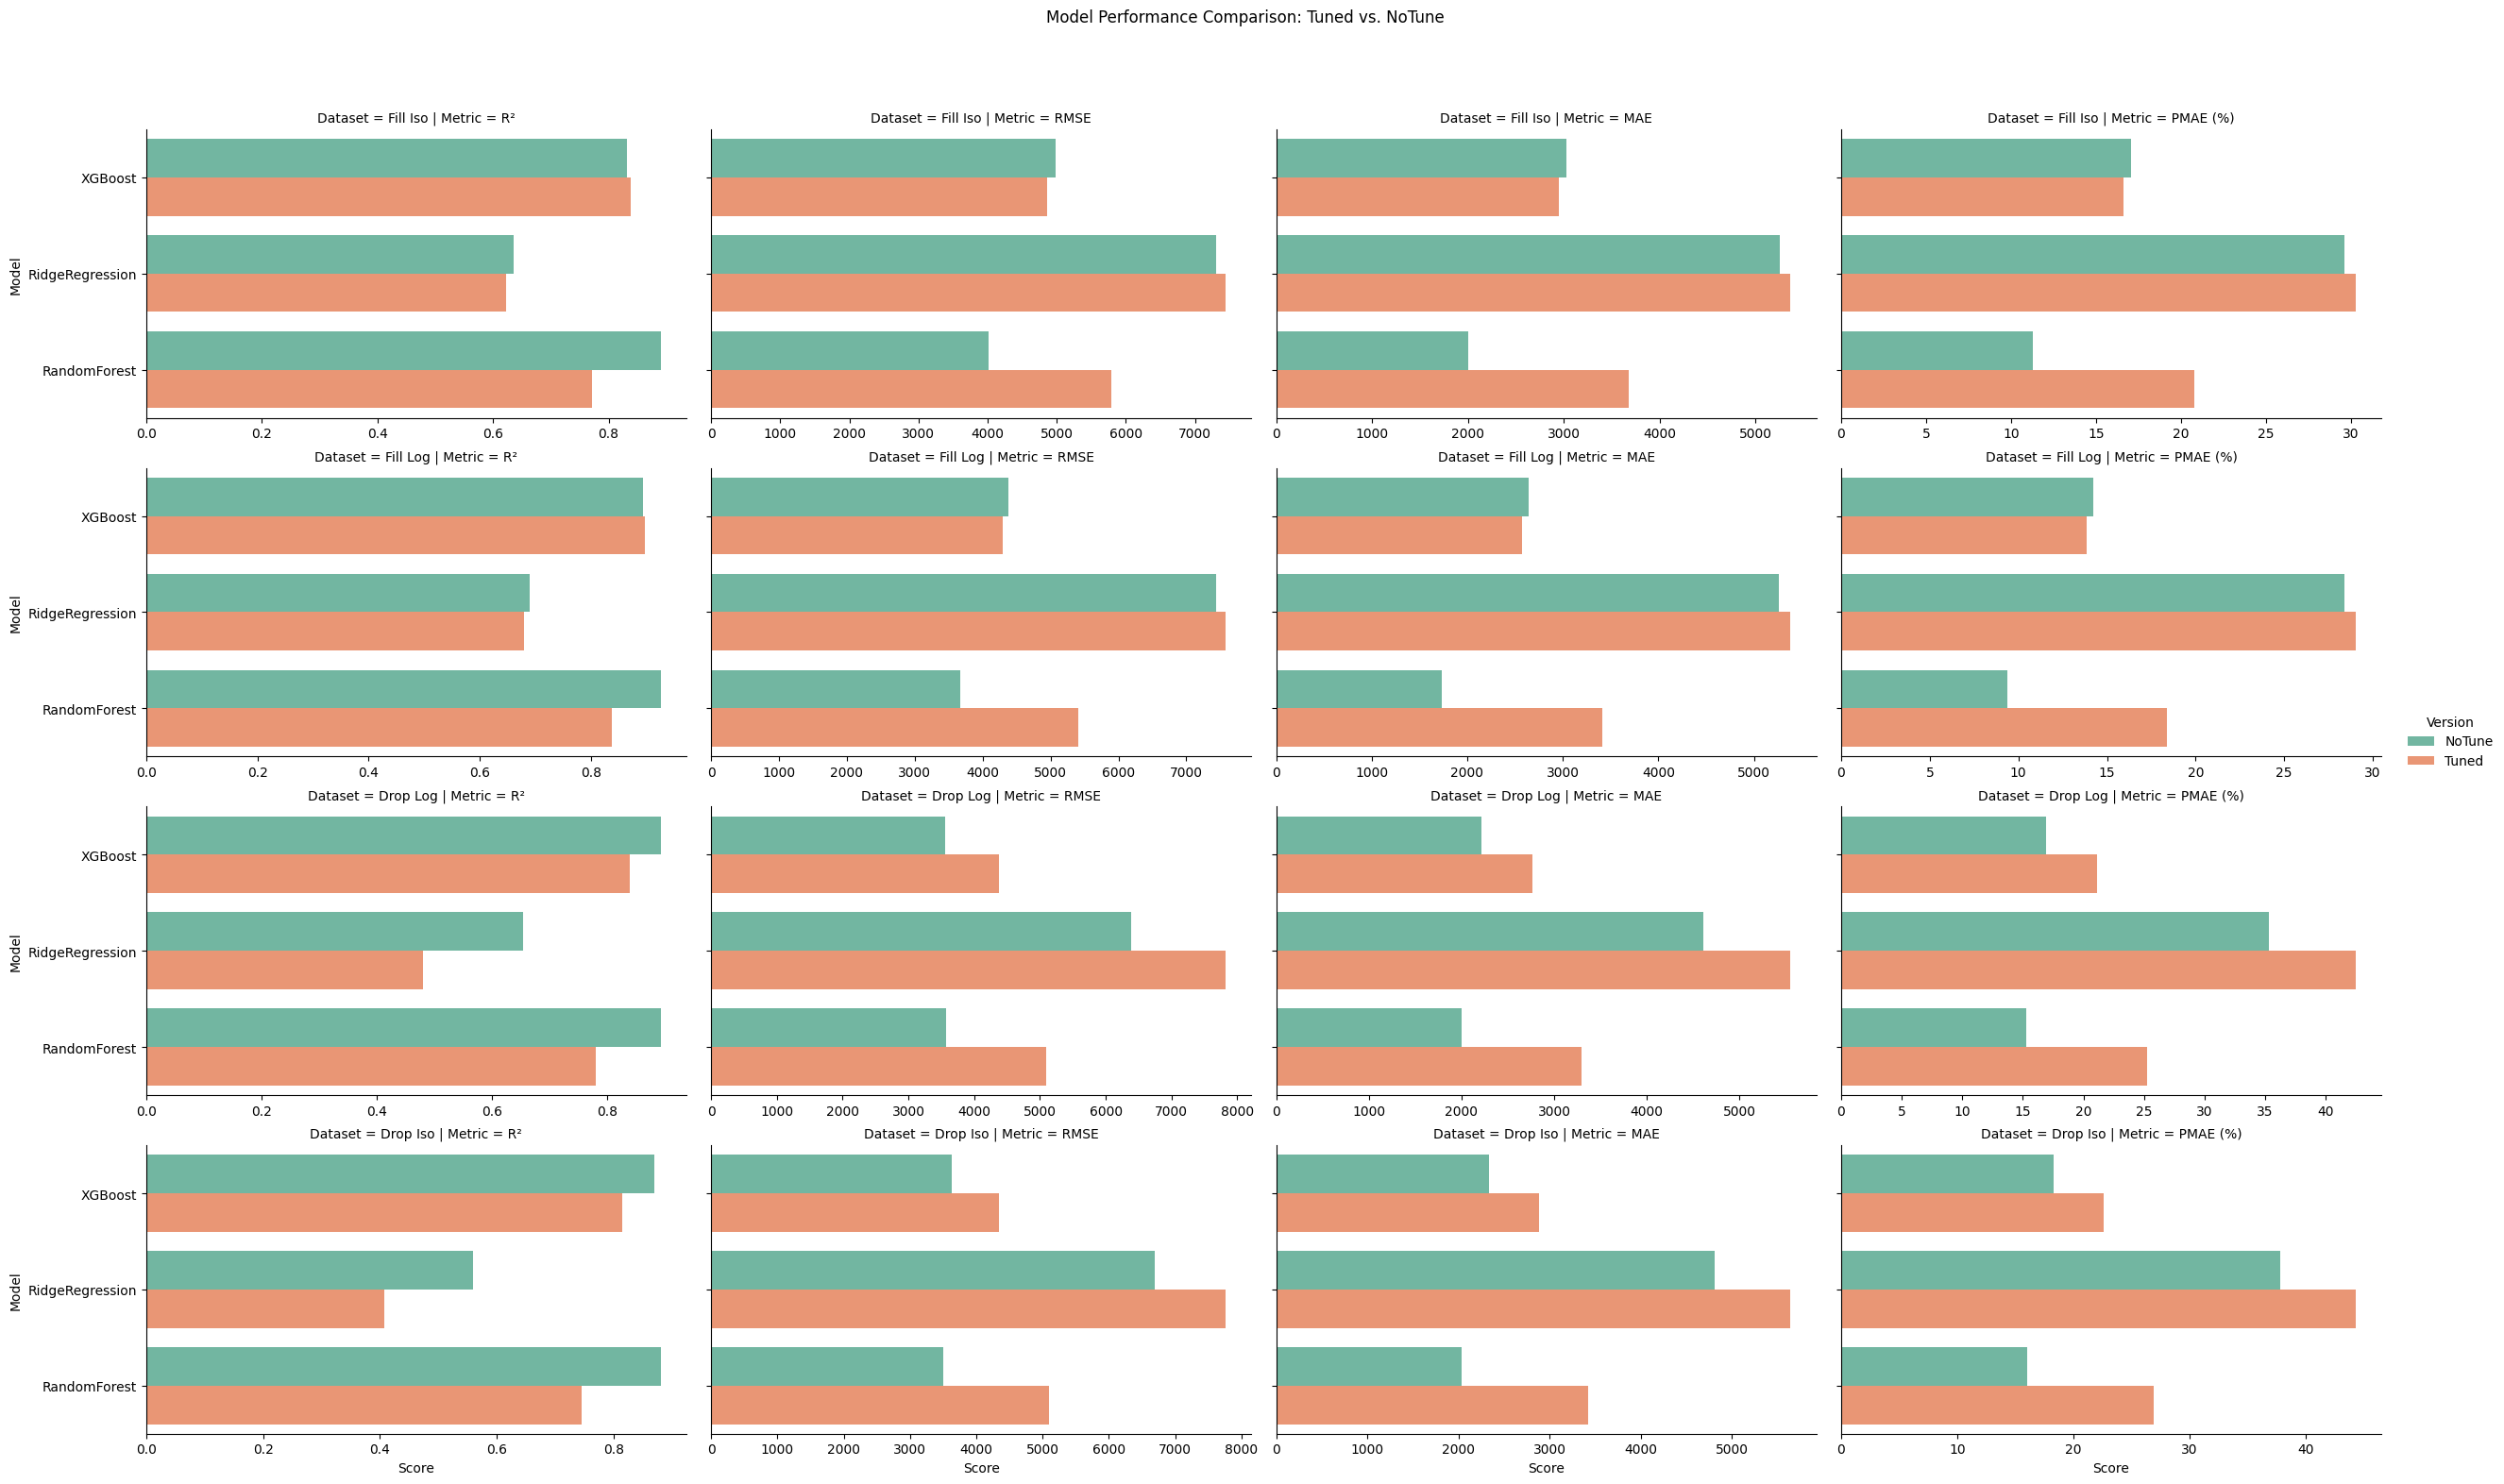

In [88]:
metrics = ["R²", "RMSE", "MAE", "PMAE (%)"]
melted = pd.melt(
    comparison,
    id_vars=["Dataset", "Model"],
    value_vars=[f"{m}_{sfx}" for m in metrics for sfx in ["NoTune", "Tuned"]],
    var_name="Metric_Version",
    value_name="Score"
)

# Split 'Metric_Version' into two columns: Metric and Version
melted[["Metric", "Version"]] = melted["Metric_Version"].str.extract(r"(.*)_((?:NoTune)|(?:Tuned))")
melted.drop(columns=["Metric_Version"], inplace=True)

# Plot
g = sns.catplot(
    data=melted,
    kind="bar",
    x="Score",
    y="Model",
    hue="Version",
    col="Metric",
    row="Dataset",
    palette="Set2",
    sharex=False,
    height=4,
    aspect=1.6
)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Model Performance Comparison: Tuned vs. NoTune")
plt.show()